#### Similarity Matrix

In [11]:
import pandas as pd
kinetics = pd.read_csv('./data/overall_distances_kinetics.csv', index_col=0)
kinetics = kinetics.round(0)
kinetics

,0,1,2,3,4,5,6,7,8,9
0,0.0,369.0,850.0,400.0,960.0,158.0,2408.0,385.0,326.0,5342.0
1,369.0,0.0,615.0,521.0,890.0,441.0,2482.0,689.0,294.0,5385.0
2,850.0,615.0,0.0,927.0,970.0,884.0,2578.0,1031.0,822.0,5435.0
3,400.0,521.0,927.0,0.0,1026.0,493.0,2072.0,642.0,407.0,5031.0
4,960.0,890.0,970.0,1026.0,0.0,991.0,2575.0,1121.0,933.0,5433.0
5,158.0,441.0,884.0,493.0,991.0,0.0,2454.0,280.0,413.0,5377.0
6,2408.0,2482.0,2578.0,2072.0,2575.0,2454.0,0.0,2447.0,2345.0,3047.0
7,385.0,689.0,1031.0,642.0,1121.0,280.0,2447.0,0.0,665.0,5370.0
8,326.0,294.0,822.0,407.0,933.0,413.0,2345.0,665.0,0.0,5229.0
9,5342.0,5385.0,5435.0,5031.0,5433.0,5377.0,3047.0,5370.0,5229.0,0.0


In [13]:
anno = pd.read_csv('./data/annotations.csv')
anno

,clones,populations
0,Clone 0,HSC_MPP
1,Clone 1,MEMP
2,Clone 2,Megakaryocyte
3,Clone 3,Mast cell
4,Clone 4,Early Erythroid
5,Clone 5,Mid Erythroid
6,Clone 6,Late Erythroid
7,Clone 7,Neutrophil-myeloid progenitor
8,Clone 8,DC
9,Clone 9,Monocyte precursor


#### Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
# torch.set_printoptions(sci_mode=False, )
np.set_printoptions(suppress=True)

from clonaltrans import pl, utils
import os

%load_ext autoreload
%autoreload 2

In [13]:
path = './examples/2Layers/EKMTime4LR001Epo1000LogN.pt'
model = torch.load(path)
device = torch.device(f"cuda:{model.config.gpu}")

In [17]:
print (model.ode_func)

ODEBlock(
  encode (clone, pop, hidden) = torch.Size([11, 11, 16]), 
  encode_bias=True, 
  decode (clone, hidden, pop) = torch.Size([11, 16, 11]), 
  decode_bias=True
  (activation): Softplus(beta=1, threshold=20)
)


In [21]:
model.matrix_K = model.get_matrix_K()

In [22]:
K = model.matrix_K

In [23]:
anno = pd.read_csv('./data/annotations.csv')

In [24]:
transition_K = pd.DataFrame(
    index=anno['populations'].values, 
    columns=anno['populations'].values, 
    data=K.detach().cpu().numpy()[8]
)

In [25]:
model.matrix_K[8, 9, 9]

tensor(1.0668e-05, device='cuda:0', grad_fn=<SelectBackward0>)

In [28]:
model.matrix_K[8, 9, 9] - model.ode_func.K2[8, 9]

tensor(2.6336e-07, device='cuda:0', grad_fn=<SubBackward0>)

In [29]:
model.ode_func.K1[8, 9, 9]

tensor(-0.0005, device='cuda:0', grad_fn=<SelectBackward0>)

In [26]:
model.ode_func.K2[8, 9]

tensor(1.0405e-05, device='cuda:0', grad_fn=<SelectBackward0>)

In [27]:
torch.square(model.ode_func.K1)[8, 9, 9]

tensor(2.6336e-07, device='cuda:0', grad_fn=<SelectBackward0>)

<AxesSubplot: >

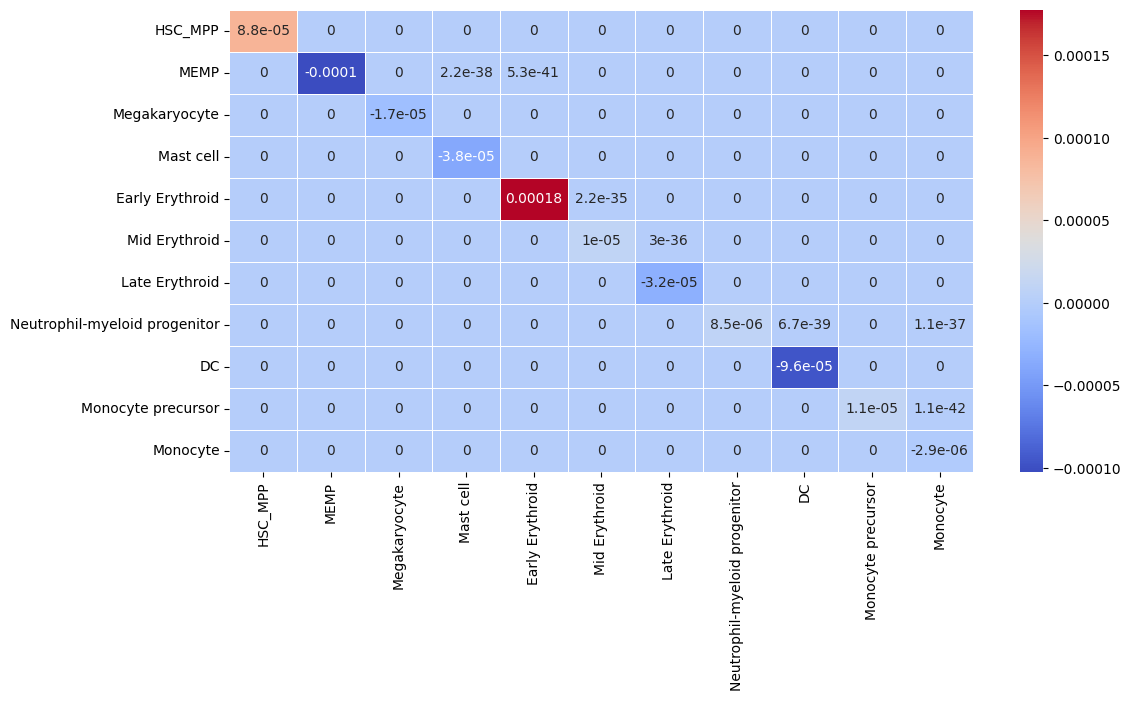

In [30]:
fig, axes = plt.subplots(figsize=(12, 6))
sns.heatmap(transition_K, annot=True, linewidths=.5, cmap='coolwarm', ax=axes)